# Laboratorium 5

In [1]:
import numpy as np
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
from scipy.special import ndtri

np.random.seed(123)

In [2]:
def variance(probe, mean):
    return np.sum((probe - mean)**2) / (len(probe) - 1)

In [3]:
def d(S0, T, K, sigma, r, sign):
    return (np.log(S0/K) + (r + sign * sigma**2 / 2)*T)/(sigma * np.sqrt(T))

In [4]:
def theoretical_price(S0, T, K, sigma, r):
    return S0 * norm.cdf(d(S0, T, K, sigma, r, 1))  - K*np.exp(-r*T) * norm.cdf(d(S0, T, K, sigma, r, -1))

In [5]:
im = theoretical_price(100, 1, 80, 1, 0.1)
print(f'Cena opcji call In The Money: {im:.2f}')
om = theoretical_price(100, 1, 120, 1, 0.1)
print(f'Cena opcji call Out Of The Money: {om:.2f}')

Cena opcji call In The Money: 48.37
Cena opcji call Out Of The Money: 35.77


In [6]:
def get_ST(S0, T, sigma, r, n):
    X = np.random.normal(0, 1, n)
    X = sigma*np.sqrt(T)*X + (r - sigma**2 / 2)*T
    return S0 * np.exp(X)

## Zadanie 1
a) Monte Carlo

In [26]:
def Monte_Carlo(S0, T, sigma, r, K, n=10**8):
    ST = get_ST(S0, T, sigma, r, n)
    probe = np.exp(-r*T) * np.maximum(ST - K, [0])
    lower = 10**4
    prices = np.zeros((n - 10**4)//10**4)
    prices[0] = np.sum(probe[0:lower])
    for i in range(1, len(prices)):
        prices[i] = prices[i-1] + np.sum(probe[lower:lower+10**4])
        lower += 10**4
    prices /= np.arange(10**4, n, 10**4)
    var = variance(probe, prices[-1])
    return prices, var

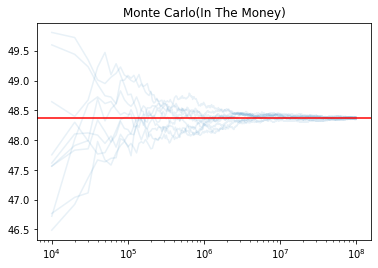

In [27]:
var_ls = []
for i in range(10):
    prices, var = Monte_Carlo(100, 1, 1, 0.1, 80)
    var_ls.append(var)
    plt.plot(np.arange(10**4, 10**8, 10**4), prices, color='C0', alpha=0.1)
plt.axhline(y=im, color='r', linestyle='-')
plt.xscale('log')
plt.title('Monte Carlo(In The Money)')
plt.show()

In [28]:
print(f'Wariancja: {np.mean(var_ls):.2f}')

Wariancja: 14673.24


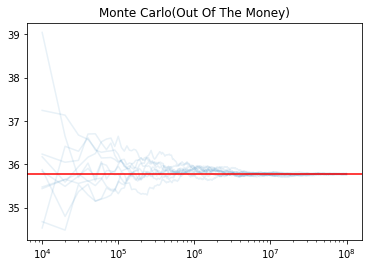

In [29]:
var_ls = []
for i in range(10):
    prices, var = Monte_Carlo(100, 1, 1, 0.1, 120)
    var_ls.append(var)
    plt.plot(np.arange(10**4, 10**8, 10**4), prices, color='C0', alpha=0.1)
plt.axhline(y=om, color='r', linestyle='-')
plt.xscale('log')
plt.title('Monte Carlo(Out Of The Money)')
plt.show()

In [30]:
print(f'Wariancja: {np.mean(var_ls):.2f}')

Wariancja: 12719.30


b) Zmienne kontrolne

Niech $X \sim N(0, 1)$, wtedy

$k(S_T) = e^{-rT}S_T \Rightarrow \mathbb{E}(k(S_T)) = e^{-rT}\mathbb{E}(S_0e^{σ\sqrt{T}X+(r − \sigma^2/2)T}) = S_0 e^{(r − \sigma^2/2)T + T\sigma^2/2 - rT}= S_0$

In [31]:
def control_vars(S0, T, sigma, r, K, n=10**8):
    ST = get_ST(S0, T, sigma, r, n)
    probe = -np.exp(-r*T) * np.minimum(ST, [K])
    lower = 10**4
    prices = np.zeros((n - 10**4)//10**4)
    prices[0] = np.sum(probe[0:lower])
    for i in range(1, len(prices)):
        prices[i] = prices[i-1] + np.sum(probe[lower:lower+10**4])
        lower += 10**4
    prices /= np.arange(10**4, n, 10**4)
    var = variance(probe, prices[-1])
    prices += S0
    return prices, var

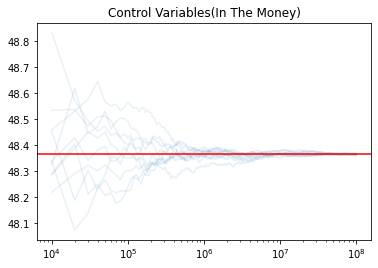

In [32]:
var_ls = []
for i in range(10):
    prices, var = control_vars(100, 1, 1, 0.1, 80)
    var_ls.append(var)
    plt.plot(np.arange(10**4, 10**8, 10**4), prices, color='C0', alpha=0.1)
plt.axhline(y=im, color='r', linestyle='-')
plt.xscale('log')
plt.title('Control Variables(In The Money)')
plt.show()

In [33]:
print(f'Wariancja: {np.mean(var_ls):.2f}')

Wariancja: 514.13


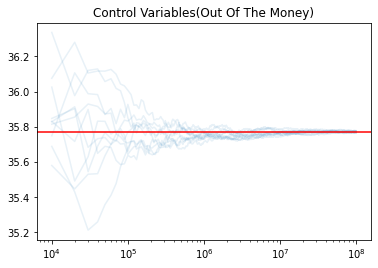

In [34]:
var_ls = []
for i in range(10):
    prices, var = control_vars(100, 1, 1, 0.1, 120)
    var_ls.append(var)
    plt.plot(np.arange(10**4, 10**8, 10**4), prices, color='C0', alpha=0.1)
plt.axhline(y=om, color='r', linestyle='-')
plt.xscale('log')
plt.title('Control Variables(Out Of The Money)')
plt.show()

In [35]:
print(f'Wariancja: {np.mean(var_ls):.2f}')

Wariancja: 1301.73


c) turbo zmienne kontrolne

In [36]:
def get_b(S0, T, sigma, r, K, n=1000):
    ST = get_ST(S0, T, sigma, r, n)
    ST = ST - np.mean(ST)
    probe = np.exp(-r*T) * np.maximum(ST - K, [0])
    probe = probe - np.mean(probe)
    return np.sum(ST * probe)/np.sum(ST**2)

def turbo_control_vars(S0, T, sigma, r, K, b, n=10**8):
    ST = get_ST(S0, T, sigma, r, n)
    probe = np.exp(-r*T) * np.maximum(ST - K, [0]) - b * ST
    lower = 10**4
    prices = np.zeros((n - 10**4)//10**4)
    prices[0] = np.sum(probe[0:lower])
    for i in range(1, len(prices)):
        prices[i] = prices[i-1] + np.sum(probe[lower:lower+10**4])
        lower += 10**4
    prices /= np.arange(10**4, n, 10**4)
    var = variance(probe, prices[-1])
    prices += S0 * b * np.exp(r*T)
    return prices, var

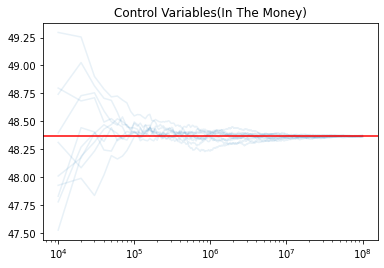

In [37]:
b = get_b(100, 1, 1, 0.1, 80)
var_ls = []
for i in range(10):
    prices, var = turbo_control_vars(100, 1, 1, 0.1, 80, b)
    var_ls.append(var)
    plt.plot(np.arange(10**4, 10**8, 10**4), prices, color='C0', alpha=0.1)
plt.axhline(y=im, color='r', linestyle='-')
plt.xscale('log')
plt.title('Control Variables(In The Money)')
plt.show()

In [38]:
print(f'Wariancja: {np.mean(var_ls):.2f}')

Wariancja: 1676.49


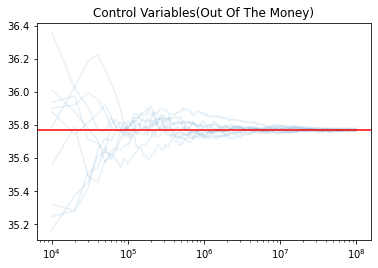

In [39]:
b = get_b(100, 1, 1, 0.1, 120)
var_ls = []
for i in range(10):
    prices, var = turbo_control_vars(100, 1, 1, 0.1, 120, b)
    var_ls.append(var)
    plt.plot(np.arange(10**4, 10**8, 10**4), prices, color='C0', alpha=0.1)
plt.axhline(y=om, color='r', linestyle='-')
plt.xscale('log')
plt.title('Control Variables(Out Of The Money)')
plt.show()

In [40]:
print(f'Wariancja: {np.mean(var_ls):.2f}')

Wariancja: 1384.94


d) zmienne antytetyczne

In [46]:
def get_ST_antithetic(S0, T, sigma, r, n):
    X = np.random.normal(0, 1, n)
    X1 = sigma*np.sqrt(T)*X + (r - sigma**2 / 2)*T
    X2 = sigma*np.sqrt(T)*(-X) + (r - sigma**2 / 2)*T
    return S0 * np.exp(X1), S0 * np.exp(X2)

def antithetic_vars(S0, T, sigma, r, K, n=10**8):
    ST1, ST2 = get_ST_antithetic(S0, T, sigma, r, n)
    probe = (np.exp(-r*T) * np.maximum(ST1 - K, [0]) + np.exp(-r*T) * np.maximum(ST2 - K, [0]))/2
    lower = 10**4
    prices = np.zeros((n - 10**4)//10**4)
    prices[0] = np.sum(probe[0:lower])
    for i in range(1, len(prices)):
        prices[i] = prices[i-1] + np.sum(probe[lower:lower+10**4])
        lower += 10**4
    prices /= np.arange(10**4, n, 10**4)
    var = variance(probe, prices[-1])
    return prices, var

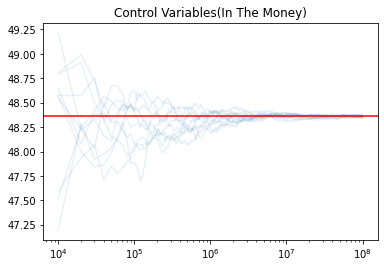

In [48]:
var_ls = []
for i in range(10):
    prices, var = antithetic_vars(100, 1, 1, 0.1, 80)
    var_ls.append(var)
    plt.plot(np.arange(10**4, 10**8, 10**4), prices, color='C0', alpha=0.1)
plt.axhline(y=im, color='r', linestyle='-')
plt.xscale('log')
plt.title('Control Variables(In The Money)')
plt.show()

In [49]:
print(f'Wariancja: {np.mean(var_ls):.2f}')

Wariancja: 6156.20


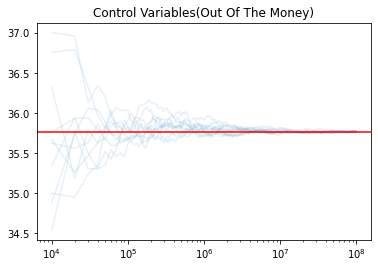

In [52]:
var_ls = []
for i in range(10):
    prices, var = antithetic_vars(100, 1, 1, 0.1, 120)
    var_ls.append(var)
    plt.plot(np.arange(10**4, 10**8, 10**4), prices, color='C0', alpha=0.1)
plt.axhline(y=om, color='r', linestyle='-')
plt.xscale('log')
plt.title('Control Variables(Out Of The Money)')
plt.show()

In [53]:
print(f'Wariancja: {np.mean(var_ls):.2f}')

Wariancja: 5713.92


e) metoda warstwowania

In [55]:
def get_ST_layers(S0, T, sigma, r, k, n):
    nk = n // k
    M = np.zeros([k, nk])
    for i in range(0, k):
        X = np.sqrt(T) * ndtri((i + uniform(0, 1).rvs(size=nk)) / k)
        X = sigma*X + (r - sigma**2 / 2)*T
        M[i,:] = S0 * np.exp(X)
    return M

def variance_layers(probe):
    return np.mean(np.var(probe, axis=1))

In [56]:
def layers_method(S0, T, sigma, r, K, k=1000, n=10**8):
    ST = get_ST_layers(S0, T, sigma, r, k, n)
    probe = np.exp(-r*T) * np.maximum(ST - K, [0])
    lower = 10
    nk = n // k
    prices = np.zeros((nk - 10)//10)
    prices[0] = np.sum(probe[:, 0:10].sum(axis=1))
    for i in range(1, len(prices)):
        prices[i] = prices[i-1] + np.sum(probe[:, lower:lower+10].sum(axis=1))
        lower += 10
    prices /= np.arange(10**4, n, 10**4)
    return prices, variance_layers(probe)

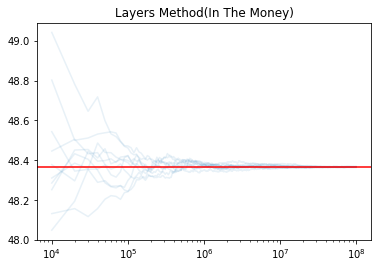

In [59]:
var_ls = []
for i in range(10):
    prices, var = layers_method(100, 1, 1, 0.1, 80)
    var_ls.append(var)
    plt.plot(np.arange(10**4, 10**8, 10**4), prices, color='C0', alpha=0.1)
plt.axhline(y=im, color='r', linestyle='-')
plt.xscale('log')
plt.title('Layers Method(In The Money)')
plt.show()

In [60]:
print(f'Wariancja: {np.mean(var_ls):.2f}')

Wariancja: 406.93


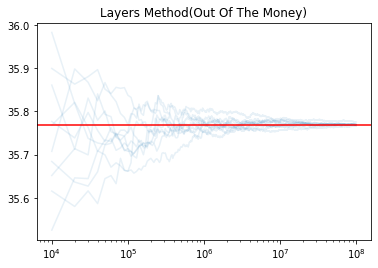

In [61]:
var_ls = []
for i in range(10):
    prices, var = layers_method(100, 1, 1, 0.1, 120)
    var_ls.append(var)
    plt.plot(np.arange(10**4, 10**8, 10**4), prices, color='C0', alpha=0.1)
plt.axhline(y=om, color='r', linestyle='-')
plt.xscale('log')
plt.title('Layers Method(Out Of The Money)')
plt.show()

In [62]:
print(f'Wariancja: {np.mean(var_ls):.2f}')

Wariancja: 409.24


f) importance sampling

In [33]:
def importance_sampling(S0, T, sigma, r, K, mu, n=10**4):
    distY = norm(loc=mu, scale=np.sqrt(T))
    distW_T = norm(loc=0, scale=np.sqrt(T))
    Y = distY.rvs(size=n)
    probe = sigma*np.sqrt(T)*Y + (r - sigma**2 / 2)*T
    probe = np.exp(-r*T) * np.maximum(S0 * np.exp(probe) - K, [0])
    probe *= distW_T.pdf(Y) / distY.pdf(Y)
    mean = np.mean(probe)
    var = np.sum((probe - mean)**2) / (n - 1)
    return mean, var

In [37]:
price, _ = importance_sampling(100, 1, 1, 0.1, 80, 1)
print(f'In The Money: estimated - {price:.2f}, real - {im:.2f}')

In The Money: estimated - 48.39, real - 48.37


In [38]:
price, _ = importance_sampling(100, 1, 1, 0.1, 120, 1)
print(f'Out Of The Money: estimated - {price:.2f}, real - {om:.2f}')

Out Of The Money: estimated - 36.21, real - 35.77


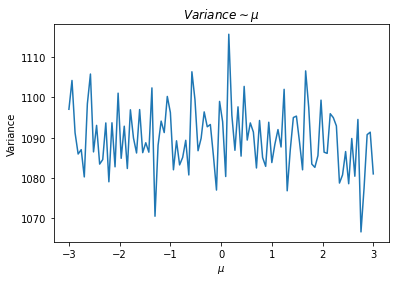

In [48]:
# In The Money
mus = np.linspace(-3, 3, 100)
var_ls = []
for i in range(len(mus)):
    _, var = importance_sampling(100, 1, 1, 0.1, 80, 1)
    var_ls.append(var)
plt.plot(mus, var_ls)
plt.xlabel('$\mu$')
plt.ylabel('Variance')
plt.title('$Variance \sim \mu$')
plt.show()

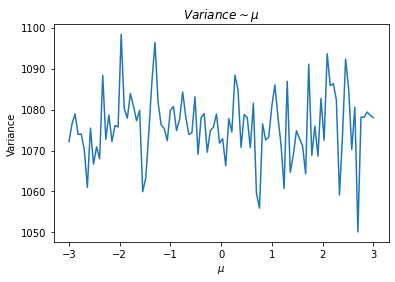

In [49]:
# Out Of The Money
mus = np.linspace(-3, 3, 100)
var_ls = []
for i in range(len(mus)):
    _, var = importance_sampling(100, 1, 1, 0.1, 120, 1)
    var_ls.append(var)
plt.plot(mus, var_ls)
plt.xlabel('$\mu$')
plt.ylabel('Variance')
plt.title('$Variance \sim \mu$')
plt.show()